In [142]:
import numpy as np
from numpy.polynomial.chebyshev import Chebyshev
import matplotlib.pyplot as plt
from matplotlib import ticker

from IPython.display import display, Latex

# Task 2

Applying the specified methods, implement an algorithm for the numerical solution of a differential equation with boundary conditions on an interval.

In [143]:
MESH = 1000

# Step size. Depends on mesh refinement
def h(start, end, m=MESH):
    return (END - START) / m

### Finite Difference Method

(1) Using the finite difference method, construct a solution for the boundary value problem for an ordinary differential equation with a chosen step size.
$$
    y'' + x y' + 2y = 4x^3 
$$
$$
    y(0.5) + y'(0.5) = 1, \quad y(1) = 2
$$

In [144]:
# Interval
START = 0.5
END = 1.0

# Step
h_fd = h(START, END)

X_fd = np.linspace(START, END, MESH)

# Ay = b
A = np.zeros((MESH, MESH))
b = np.zeros(MESH)

# i = 1
A[0, 0] = h_fd - 1
A[0, 1] = 1
b[0] = h_fd

# i in [2, n-2]
for i in range(1, MESH - 2):
    xi = X_fd[i]
    
    A[i, i - 1] = 1 - (xi * h_fd) / 2      # y_(i-1)
    A[i, i]     = -2 + 2 * h_fd ** 2       # y_i  
    A[i, i + 1] = 1 + (xi * h_fd) / 2      # y_(i+1)
    
    b[i] = 4 * h_fd ** 2 * xi ** 3

# i = n-1:
i = MESH - 2
xi = X_fd[i]

A[i, i - 1] = 1 - (xi * h_fd) / 2      # y_(n-2)
A[i, i] = -2 + 2 * h_fd ** 2           # y_(n-1)
b[i] = 4 * h_fd ** 2 * xi ** 3 - 2

# i = n
A[MESH - 1, MESH - 1] = 1
b[MESH - 1] = 2

# Solve SLAE
Y_fd = np.linalg.solve(A, b)

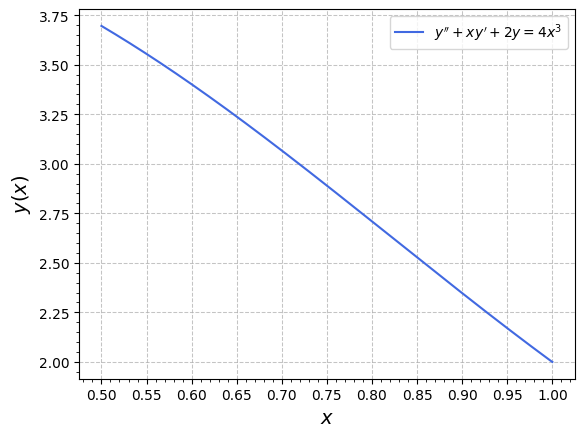

In [145]:
fig, ax = plt.subplots()

ax.set_xlabel(r"$x$", fontsize=14)
ax.set_ylabel(r"$y(x)$", fontsize=14)

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

ax.grid(True, which="major", linestyle="--", linewidth=.75, alpha=.75)

colors = [plt.cm.tab10(i) for i in range(5)]

ax.plot(
    X_fd, Y_fd,
    color='royalblue',
    label=r"$y'' + x y' + 2y = 4x^3 $"
)

plt.legend(loc='upper right')

plt.show()

### Collocation and Galerkin Methods

(2) Using the collocation method and the Galerkin method, find solutions to the differential equation
$$
    y'' - 5y' + 6y = 3
$$
$\ \  \ \ \ $with the boundary conditions $y(-1) = 0, \  y(1) = 0$.

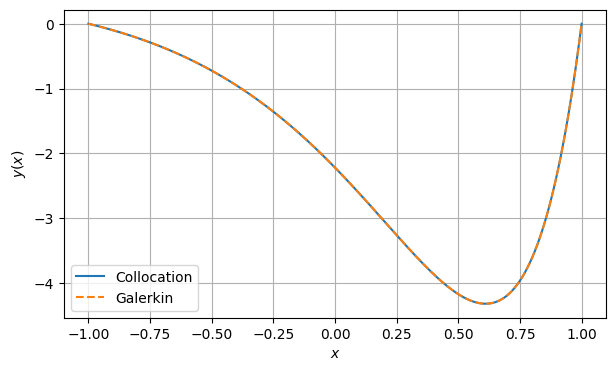

In [146]:
# BVP: y'' - 5y' + 6y = 3,  y(-1)=0, y(1)=0

N = 20  # Chebyshev degree (for both methods)

# Chebyshev–Lobatto nodes on [-1, 1] (collocation nodes)
j = np.arange(N + 1)
x_nodes = np.cos(np.pi * j / N)

# Chebyshev polynomials and derivatives
T  = [Chebyshev.basis(k) for k in range(N + 1)]
T1 = [p.deriv(1) for p in T]
T2 = [p.deriv(2) for p in T]

# ---------- Collocation ----------

# Linear system A a = b for coefficients a_k
A = np.zeros((N + 1, N + 1))
b = np.zeros(N + 1)

# y(1) = 0
x = x_nodes[0]
for k in range(N + 1):
    A[0, k] = T[k](x)
b[0] = 0.0

# Interior collocation: y'' - 5y' + 6y = 3
for i in range(1, N):
    x = x_nodes[i]
    for k in range(N + 1):
        A[i, k] = T2[k](x) - 5.0*T1[k](x) + 6.0*T[k](x)
    b[i] = 3.0

# y(-1) = 0
x = x_nodes[-1]
for k in range(N + 1):
    A[N, k] = T[k](x)
b[N] = 0.0

# Solve for collocation coefficients
coeffs_coll = np.linalg.solve(A, b)
y_coll = Chebyshev(coeffs_coll)  # y_N(x) in Chebyshev form

# ---------- Galerkin method ----------

# Trial functions: phi_k(x) = (1 - x^2) T_k(x), k = 0..N
# We enforce: integral R(x) T_j(x) w(x) dx = 0, j = 0..N
# with w(x) = 1/sqrt(1-x^2), approximated by Gauss–Chebyshev quadrature

Q = 2*(N + 1)  # number of quadrature points
m = np.arange(Q)
xq = np.cos((2*m + 1)*np.pi/(2*Q))  # Gauss–Chebyshev nodes

# Values of T_k, T_k', T_k'' at quadrature nodes
Tq  = np.zeros((Q, N + 1))
Tq1 = np.zeros((Q, N + 1))
Tq2 = np.zeros((Q, N + 1))
for k in range(N + 1):
    Tq[:, k]  = T[k](xq)
    Tq1[:, k] = T1[k](xq)
    Tq2[:, k] = T2[k](xq)

# L[phi_k](x_i) for each k and quadrature node i
Lphi = np.zeros((Q, N + 1))
for k in range(N + 1):
    Sk  = Tq[:, k]      # S(x) = T_k(x)
    S1k = Tq1[:, k]     # S'(x)
    S2k = Tq2[:, k]     # S''(x)
    x   = xq

    yk  = (1.0 - x**2)*Sk
    yk1 = -2.0*x*Sk + (1.0 - x**2)*S1k
    yk2 = -4.0*x*S1k - (x**2 - 1.0)*S2k - 2.0*Sk

    Lphi[:, k] = yk2 - 5.0*yk1 + 6.0*yk

# Galerkin matrix G and right-hand side g
G = np.zeros((N + 1, N + 1))
g = np.zeros(N + 1)

for j in range(N + 1):
    # test function is T_j(x), weight is Chebyshev weight; constant factor cancels
    Tj_vals = Tq[:, j]
    # G[j, k] = sum_i L[phi_k](x_i) * T_j(x_i)
    for k in range(N + 1):
        G[j, k] = np.sum(Lphi[:, k] * Tj_vals)
    # g[j] = 3 * sum_i T_j(x_i)
    g[j] = 3.0 * np.sum(Tj_vals)

# Solve for Galerkin coefficients (for S(x) in Chebyshev basis)
coeffs_gal = np.linalg.solve(G, g)

# Approximate solution for Galerkin:
# S(x) = sum a_k T_k(x), y(x) = (1 - x^2) * S(x)
S_gal = Chebyshev(coeffs_gal)

# ---------- Plot ----------

x_plot = np.linspace(-1, 1, 400)
y_coll_plot = y_coll(x_plot)
y_gal_plot  = (1.0 - x_plot**2) * S_gal(x_plot)

plt.figure(figsize=(7, 4))
plt.plot(x_plot, y_coll_plot, label="Collocation")
plt.plot(x_plot, y_gal_plot, "--", label="Galerkin")
plt.grid(True)
plt.xlabel(r"$x$")
plt.ylabel(r"$y(x)$")
plt.legend()

plt.show()